<a href="https://colab.research.google.com/github/aditya-saurabh/landmark-detection/blob/master/Facial_Landmark_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# uploading kaggle.json file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityasaurabh","key":"1f17dd15625e1f7a337e70697a35b92d"}'}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json


In [3]:
# downloading dataset from kaggle

!mkdir /root/.kaggle 
!cp kaggle.json /root/.kaggle
!kaggle datasets download -d drgilermo/face-images-with-marked-landmark-points 

 79% 83.0M/105M [00:00<00:00, 77.5MB/s]
100% 105M/105M [00:00<00:00, 121MB/s]  


In [4]:
# unzipping the file

!unzip /content/face-images-with-marked-landmark-points.zip -d /tmp/

Archive:  /content/face-images-with-marked-landmark-points.zip
  inflating: /tmp/face_images.npz    
  inflating: /tmp/facial_keypoints.csv  


In [0]:
# reading the dataset

images = np.load('/tmp/face_images.npz')['face_images']
landmarks = pd.read_csv('/tmp/facial_keypoints.csv')

In [6]:
# checking data shape and size

(width, height, num_images) = images.shape
print(f'Total number of images is {num_images} \nWidth, Height of image is {width, height}')

print(landmarks.head())

Total number of images is 7049 
Width, Height of image is (96, 96)
   left_eye_center_x  ...  mouth_center_bottom_lip_y
0          66.033564  ...                  84.485774
1          64.332936  ...                  85.480170
2          65.057053  ...                  78.659368
3          65.225739  ...                  78.268383
4          66.725301  ...                  86.871166

[5 rows x 30 columns]


In [7]:
# exploratory data analysis

landmarks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

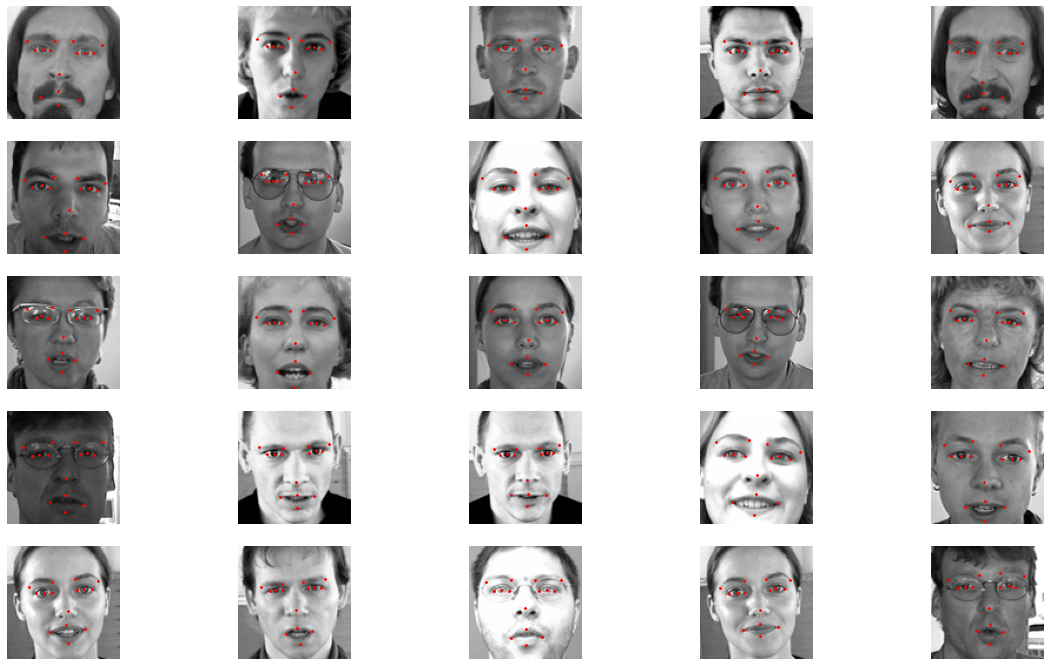

In [9]:
# plotting image
n = 5
plt.figure(figsize=(20,12))
for i in range (n*n):
  face_landmark = np.array(landmarks.iloc[i], dtype=np.uint8)
  image = images[:,:,i]
  plt.subplot(n, n, i+1)
  plt.imshow(image, cmap='gray')
  plt.axis('off')

  for i in range(int(len(face_landmark)/2)):
    plt.scatter(face_landmark[2*i], face_landmark[2*i+1], c='red', s=3)
plt.show()


In [10]:
landmarks.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [11]:
# extracting indices with not null values

indices = landmarks.index.tolist()
indices_not_null = (landmarks.dropna(how='any', axis=0)).index.tolist()

print(f'Rows which are not null are {len(indices_not_null)}')

Rows which are not null are 2140


In [12]:
# preparing image for training

indices_not_null = np.array(indices_not_null)
sort = np.argsort(indices_not_null)

image_train = []
face_landmarks = []
for i in range(len(sort)):
  image_train.append(images[:,:,indices_not_null[sort[i]]])
  face_landmark = (landmarks.iloc[indices_not_null[sort[i]]]).tolist()
  face_landmarks.append(face_landmark)

image_train = np.array(image_train)
face_landmarks = np.array(face_landmarks)

print(f'Shape of the training images {image_train.shape}, and that of the labels is {face_landmarks.shape}')

Shape of the training images (2140, 96, 96), and that of the labels is (2140, 30)


In [0]:
# normalizing the data

image_train = np.expand_dims(image_train, axis=-1)
image_train = image_train/255.0

face_landmarks = face_landmarks/96.0
face_landmarks = np.reshape(face_landmarks, (face_landmarks.shape[0], 1, 1, face_landmarks.shape[1]))

In [0]:
import random

def train_test_split(X, y, split_size=0.9):
  length = X.shape[0]
  index = random.sample(range(length), int(split_size*length))

  X_train = []
  X_test = []
  y_train = []
  y_test = []

  for i in range (length):
    if i in index:
      X_train.append(X[i])
      y_train.append(y[i])
    else:
      X_test.append(X[i])
      y_test.append(y[i])
  
  X_train = np.array(X_train)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  print(f'Shape of X_train = {X_train.shape}\n y_train = {y_train.shape}\n X_test = {X_test.shape}\n y_test = {y_test.shape} ')

  return (X_train, y_train), (X_test, y_test)

In [15]:
(X_train, y_train), (X_test, y_test) = train_test_split(image_train, face_landmarks)

Shape of X_train = (1926, 96, 96, 1)
 y_train = (1926, 1, 1, 30)
 X_test = (214, 96, 96, 1)
 y_test = (214, 1, 1, 30) 


In [16]:
# defining the neural network

model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(96,96,1)),
                tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(2),
                tf.keras.layers.BatchNormalization(),

                tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(2),
                tf.keras.layers.BatchNormalization(),

                tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(2),
                tf.keras.layers.BatchNormalization(),

                tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
                tf.keras.layers.MaxPooling2D(2),
                tf.keras.layers.BatchNormalization(),

             

                tf.keras.layers.Conv2D(64, (5,5), padding='valid', activation='relu'),
                tf.keras.layers.Conv2D(30, (3,3), strides=(2,2), padding='same', activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        2

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80)

Epoch 1/80
61/61 [==============================] - 2s 32ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0122 - val_mse: 0.0122
Epoch 2/80
61/61 [==============================] - 1s 24ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 3/80
61/61 [==============================] - 1s 24ms/step - loss: 7.5303e-04 - mse: 7.5303e-04 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 4/80
61/61 [==============================] - 1s 24ms/step - loss: 6.0655e-04 - mse: 6.0655e-04 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 5/80
61/61 [==============================] - 1s 24ms/step - loss: 5.2239e-04 - mse: 5.2239e-04 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 6/80
61/61 [==============================] - 1s 24ms/step - loss: 4.4851e-04 - mse: 4.4851e-04 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 7/80
61/61 [==============================] - 1s 24ms/step - loss: 3.9504e-04 - mse: 3.9504e-04 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/80
61/61 [=========================

In [0]:
model.save('landmark.h5')

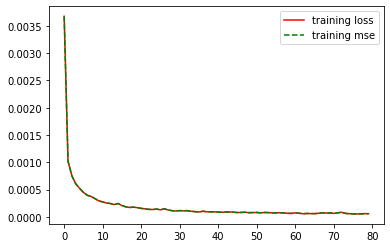

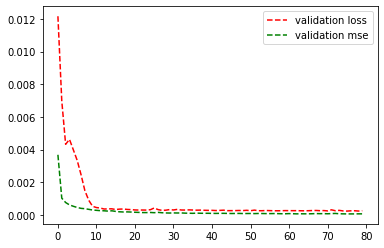

In [20]:
# plotting results

loss = history.history['loss']
mse = history.history['mse']
epochs = range(len(loss))

plt.plot(epochs, loss, '-r', label = 'training loss')
plt.plot(epochs, loss, '--g', label = 'training mse')
plt.legend()
plt.show()


val_loss = history.history['val_loss']
val_mse = history.history['val_mse']
epochs = range(len(loss))

plt.plot(epochs, val_loss, '--r', label = 'validation loss')
plt.plot(epochs, loss, '--g', label = 'validation mse')
plt.legend()
plt.show()

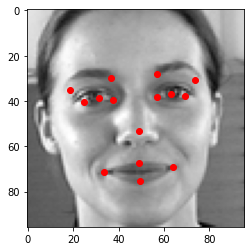

In [24]:
# testing

index = 0
img = X_test[index:index+1]
label = 96.0*np.reshape((model.predict(img)), (30,))

plt.imshow(np.reshape(img, (96,96)), cmap='gray')

for i in range(int(len(label)/2)):
  plt.scatter(label[2*i], label[2*i+1], c='red')

plt.show()

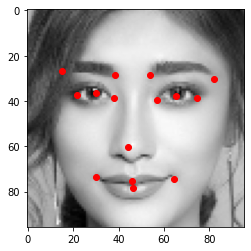

In [28]:
# testing for your custom image

import cv2

path = '/content/adult-attractive-beautiful-beauty-415829.jpg'  # put the path of your image
img = cv2.imread(path)

face_extract = cv2.CascadeClassifier('/content/haarcascade_frontalface_alt.xml')
bb = face_extract.detectMultiScale(img, 1.1, 3)

for (x, y, w, h) in bb:
  face = img[y:y+h, x:x+w]

gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (96,96))

gray = np.reshape(gray, (1,96,96,1))

gray = gray/255.0

label = 96.0*np.reshape((model.predict(gray)), (30,))

plt.imshow(np.reshape(gray, (96,96)), cmap='gray')

for i in range(int(len(label)/2)):
  plt.scatter(label[2*i], label[2*i+1], c='red')

plt.show()